### MSIN0097 Predictive Analytics - Individual Assignment

#### A sentiment analysis on financial news headlines

## Table of contents
* [1. Introduction](#one)
* [2. Data Loading & Functions](#two)
* [3. EDA](#three)
* [4. Preprocessing](#four)
* [5. Model 1: Linear Regression](#five)
* [6. Model 2: Decision Tree](#six)
* [7. Model 3: Random Forest Classifier](#seven)
    * [7.1 Grid Search Cross Validation](#seven-one)
    * [7.2 Grid Search Cross Validation Visualisations](#seven-two)
    * [7.3 Best Model Performance](#seven-three)
* [8. Multi Layer perceptron](#eight)
   * [8.1 Random Search](#eight-one)
* [9. Recurrent Neural Network](#nine)
  * [9.1 Random Search](#nine-one)

### 2. Data Loading & Functions <a class="anchor" id="two"></a>

In [ ]:
# Basic packages
import collections
import numpy as np
import pandas as pd
import pickle
import random
import re
from pathlib import Path
import nbformat

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Data preparation and vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Input
from tensorflow.keras.optimizers import Adam

# Keras additional imports (if needed)
from keras import models
from keras import regularizers

# Modeling - Classical ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Hyperparameter Tuning
import keras_tuner as kt
from keras_tuner import HyperModel, RandomSearch

# Model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
# preprocessing the text data
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text within brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  # Remove punctuations
    text = re.sub(r'\n', ' ', text)  # Replace newline characters with space
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Trains a neural network model using specified training and validation datasets.

    Args:
        model: A neural network model instance.
        X_train: Numpy array of training data.
        y_train: Numpy array of training labels.
        X_valid: Numpy array of validation data.
        y_valid: Numpy array of validation labels.

    Returns:
        A history object containing training and validation metrics.
    '''
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_valid, y_valid), verbose=0)
    return history

def eval_metric(model, history, metric_name):
    '''
    Evaluates and plots a metric from the training history of a model.

    Args:
        model: The model being evaluated.
        history: Training history object.
        metric_name: Name of the metric to plot ('loss' or 'accuracy').

    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    epochs = range(1, NB_START_EPOCHS + 1)

    plt.plot(epochs, metric, 'o-', label='Train ' + metric_name.capitalize())
    plt.plot(epochs, val_metric, '-', label='Validation ' + metric_name.capitalize())
    plt.xlabel('Epoch Number')
    plt.ylabel(metric_name.capitalize())
    plt.title('Training vs Validation ' + metric_name.capitalize())
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Retrains the model on full training data and evaluates it on the test set.

    Args:
        model: The trained model.
        X_train: Training data features.
        y_train: Training data labels.
        X_test: Test data features.
        y_test: Test data labels.
        epoch_stop: Number of epochs to use for retraining.

    Returns:
        Tuple containing test loss and accuracy.
    '''
    model.fit(X_train, y_train, epochs=epoch_stop, batch_size=BATCH_SIZE, verbose=0)
    results = model.evaluate(X_test, y_test)
    print(f'\nTest accuracy: {results[1] * 100:.2f}%')
    return results

def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Compares a specific metric between two models over epochs.

    Args:
        model_hist_1: Training history of the first model.
        model_hist_2: Training history of the second model.
        metric: Metric name to compare ('loss', 'acc', 'val_loss', 'val_acc').

    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    epochs = range(1, NB_START_EPOCHS + 1)

    plt.plot(epochs, metric_model_1, 'o-', label=model_1.name + ' ' + metric)
    plt.plot(epochs, metric_model_2, 'r--', label=model_2.name + ' ' + metric)
    plt.xlabel('Epoch Number')
    plt.ylabel(metric.capitalize())
    plt.title('Comparison of ' + metric.capitalize() + ' Between Models')
    plt.legend()
    plt.show()

def optimal_epoch(model_hist):
    '''
    Determines the optimal epoch number where the validation loss is at its minimum.

    Args:
        model_hist: Training history of the model.

    Returns:
        Epoch number with the minimum validation loss.
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Optimal epoch for minimum validation loss is: {}".format(min_epoch))
    return min_epoch

In [ ]:
# Model configuration constants:
NB_WORDS = 10000  # Maximum vocabulary size
NB_START_EPOCHS = 30  # Number of epochs for initial training
BATCH_SIZE = 512  # Batch size for gradient descent
MAX_LEN = 20  # Maximum length of text sequences

In [ ]:
# data loading
df = pd.read_csv('/content/Sentences_AllAgree_converted.csv', encoding='ISO-8859-1')

### 3. EDA <a class="anchor" id="three"></a>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2264 non-null   object
 1   Label     2264 non-null   object
dtypes: object(2)
memory usage: 35.5+ KB


<ipython-input-6-ee3f13059273>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')


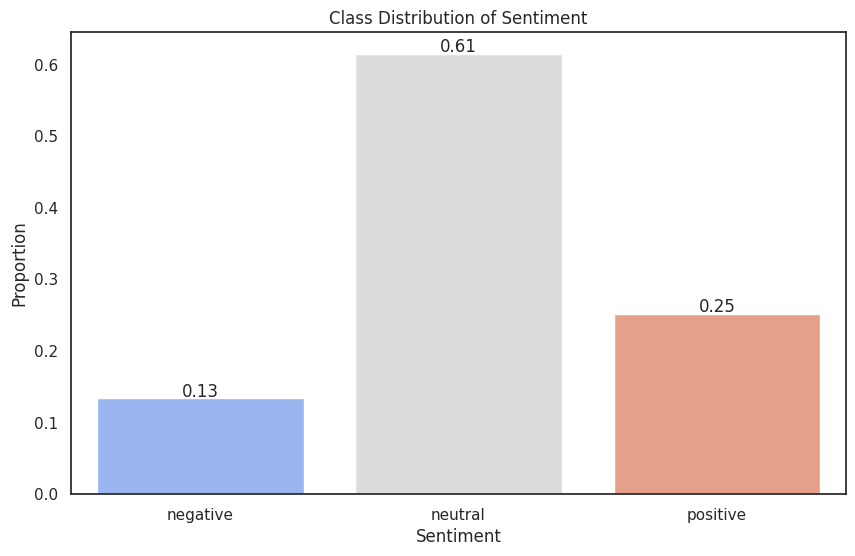

In [ ]:
# Load the sentiment classification counts
class_counts = df['Label'].value_counts(normalize=True).sort_index()

# Set a clean white background for the plots
sns.set(style="white")

# Define the size of the plot
plt.figure(figsize=(10, 6))

# Plot the data using a bar chart
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')

# Add a title and labels to the x and y axes for clarity
plt.title('Class Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')
plt.show()


In [ ]:
# sentence length analysis
df['sentence_length'] = df['Sentence'].apply(len)
print(df['sentence_length'].describe())

count    2264.000000
mean      121.962456
std        56.238979
min         9.000000
25%        79.000000
50%       111.000000
75%       157.000000
max       315.000000
Name: sentence_length, dtype: float64


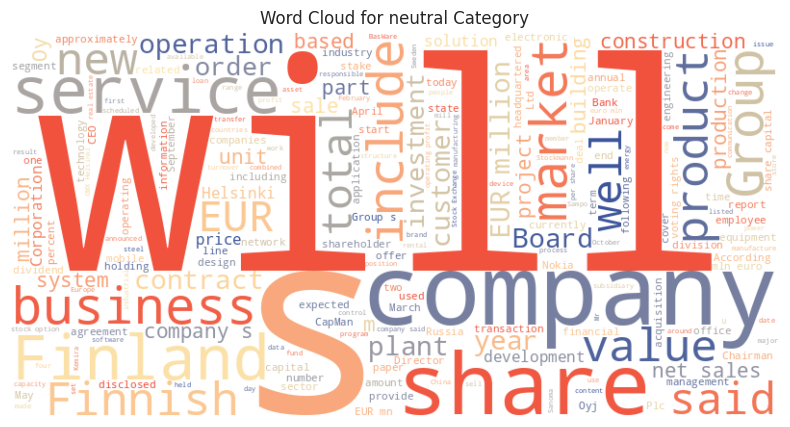

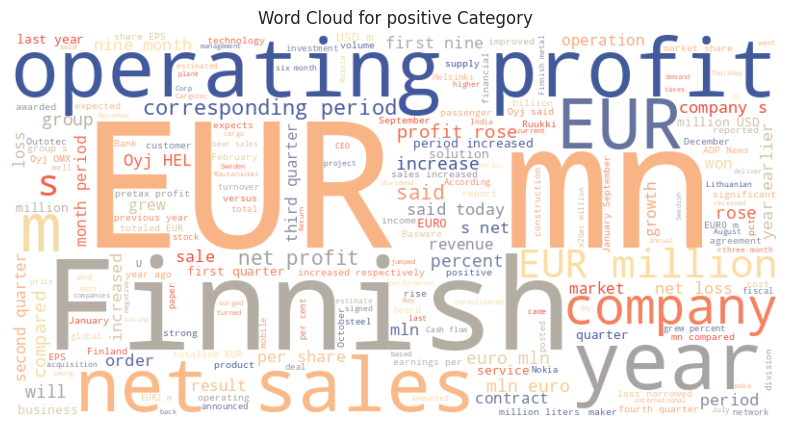

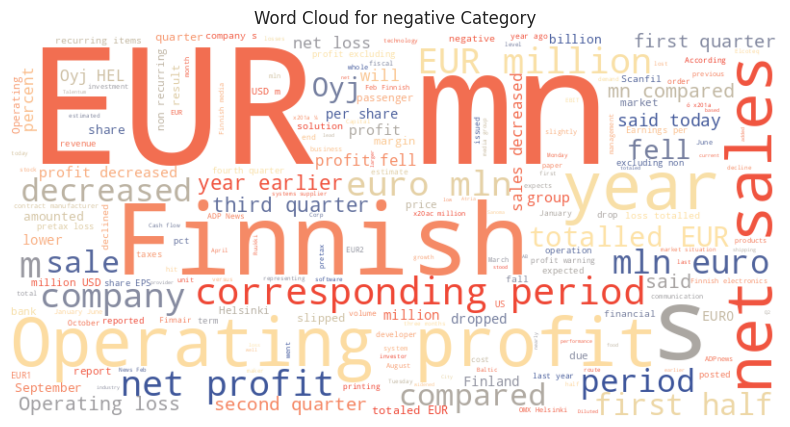

In [ ]:
# Define a color map
color_map = LinearSegmentedColormap.from_list("coolwarm", ["#3A539B", "#FDE3A7", "#EF4836"])

# Split the DataFrame by label categories
categories = df['Label'].unique()

# Create a word cloud for each category
for category in categories:
    # Combine all sentences from the current category into a single string
    text = ' '.join(df[df['Label'] == category]['Sentence'])

    # Generate the word cloud with the defined color map
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color_map).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category} Category')
    plt.axis('off')
    plt.show()

### 4. Preprocessing <a class="anchor" id="four"></a>

In [ ]:
# applying the cleaning function to the sentence column
df['cleaned_sentence'] = df['Sentence'].apply(clean_text)

In [ ]:
# drop the original 'Sentence' column
df = df.drop('Sentence', axis=1)
# rename 'cleaned_sentence' to 'Sentence'
df = df.rename(columns={'cleaned_sentence': 'Sentence'})

In [ ]:
# shuffle the order of the df to ensure randomness
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))

In [ ]:
df.head()

,Label,Sentence
1755,neutral,the contract value amounts to eur million
1281,neutral,kemira shares closed at
350,negative,the company slipped to an operating loss of eu...
420,positive,according to atria s president and ceo matti t...
56,positive,in fiskars cash flow from operating activit...


In [ ]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Label'], test_size=0.1, random_state=42)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 2037
# Test data samples: 227


In [ ]:
X = df['Sentence']
# initializes a tokenizer and fit it on the training data
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X)

In [ ]:
df.head()

,Label,Sentence
1755,neutral,the contract value amounts to eur million
1281,neutral,kemira shares closed at
350,negative,the company slipped to an operating loss of eu...
420,positive,according to atria s president and ceo matti t...
56,positive,in fiskars cash flow from operating activit...


In [ ]:
# convert training and testing text data to binary matrix representations
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [ ]:
# combine the train and test labels to fit the LabelEncoder on all possible labels
all_labels = pd.concat([y_train, y_test])

le = LabelEncoder()
le.fit(all_labels)

# transform the train and test labels to numerical values
y_train_le = le.transform(y_train)
y_test_le = le.transform(y_test)

# convert the numerical labels to one-hot encoding
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

# to see the conversion for the first label in your training set
print(f'"{y_train.iloc[8]}" is converted into {y_train_le[8]}')
print(f'"{y_train_le[8]}" is converted into {y_train_oh[8]}')

"positive" is converted into 2
"2" is converted into [0. 0. 1.]


In [ ]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=42)
assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]
print('Shape of validation set:',X_valid.shape)

Shape of validation set: (204, 10000)


In [ ]:
# vectorize the text data
vectorizer = TfidfVectorizer(max_features=10000)
X_vectorized = vectorizer.fit_transform(df['Sentence']).toarray()

# encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Label'])

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.1, random_state=42)

### 5. Model 1: Logistic Regression <a class="anchor" id="five"></a>

In [ ]:
# initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# fit the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.8370044052863436

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.45      0.58        29
     neutral       0.82      0.99      0.90       136
    positive       0.89      0.68      0.77        62

    accuracy                           0.84       227
   macro avg       0.84      0.71      0.75       227
weighted avg       0.84      0.84      0.82       227



### 6. Model 2: Decision Tree <a class="anchor" id="six"></a>

In [ ]:
# initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# train the classifier on the training data
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.8502202643171806

Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.66      0.66        29
     neutral       0.89      0.93      0.91       136
    positive       0.86      0.77      0.81        62

    accuracy                           0.85       227
   macro avg       0.80      0.79      0.79       227
weighted avg       0.85      0.85      0.85       227



### 7. Model 3:  Random Forest Classifier <a class="anchor" id="seven"></a>

In [ ]:
# initialize the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# after training, predictions are made and the model is evaluated
predictions = rf_classifier.predict(X_test)

# evaluation
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.41      0.56        29
           1       0.85      1.00      0.92       136
           2       0.83      0.71      0.77        62

    accuracy                           0.85       227
   macro avg       0.85      0.71      0.75       227
weighted avg       0.85      0.85      0.83       227

Accuracy: 0.8458149779735683


#### 7.1 Grid Search Cross Validation <a class="anchor" id="seven-one"></a>

In [ ]:
# specify the hyperparameters we want to tune and their respective ranges
param_grid = {
    'n_estimators': [100, 200, 300],  # number of trees in the forest
    'max_depth': [None, 10, 20, 40],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # minimum number of samples required at each leaf node
}

In [ ]:
# initialize the classifier
rf = RandomForestClassifier(random_state=42)

# initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

In [ ]:
# running GridSearchCV on the training data to find the RandomForestClassifier's
# best hyperparameter combination based on cross-validation scores.
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
# retrieving the best combination of parameters from the grid search
best_params = grid_search.best_params_

# save the best parameters to a file
with open('best_params.pickle', 'wb') as f:
    pickle.dump(best_params, f)

print("Best parameters saved to best_params.pickle")

Best parameters saved to best_params.pickle


In [ ]:
# print the best hyperparameters found by grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# evaluate the best model directly on your test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# evaluating the  best model on the test set
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Cross-validation Score: 0.8419292286939346
Accuracy on Test Set: 0.8502202643171806
              precision    recall  f1-score   support

           0       0.92      0.41      0.57        29
           1       0.86      1.00      0.92       136
           2       0.82      0.73      0.77        62

    accuracy                           0.85       227
   macro avg       0.87      0.71      0.75       227
weighted avg       0.85      0.85      0.84       227



In [ ]:
# convert the grid search results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# aggregate results to ensure unique index-column pairs for the pivot
agg_results = results_df.groupby(['param_n_estimators', 'param_max_depth'])['mean_test_score'].mean().reset_index()

In [ ]:
# pivot the aggregated results for visualisations
pivot_table = agg_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

#### 7.2 Grid Search Cross Validation Visualisations <a class="anchor" id="seven-two"></a>

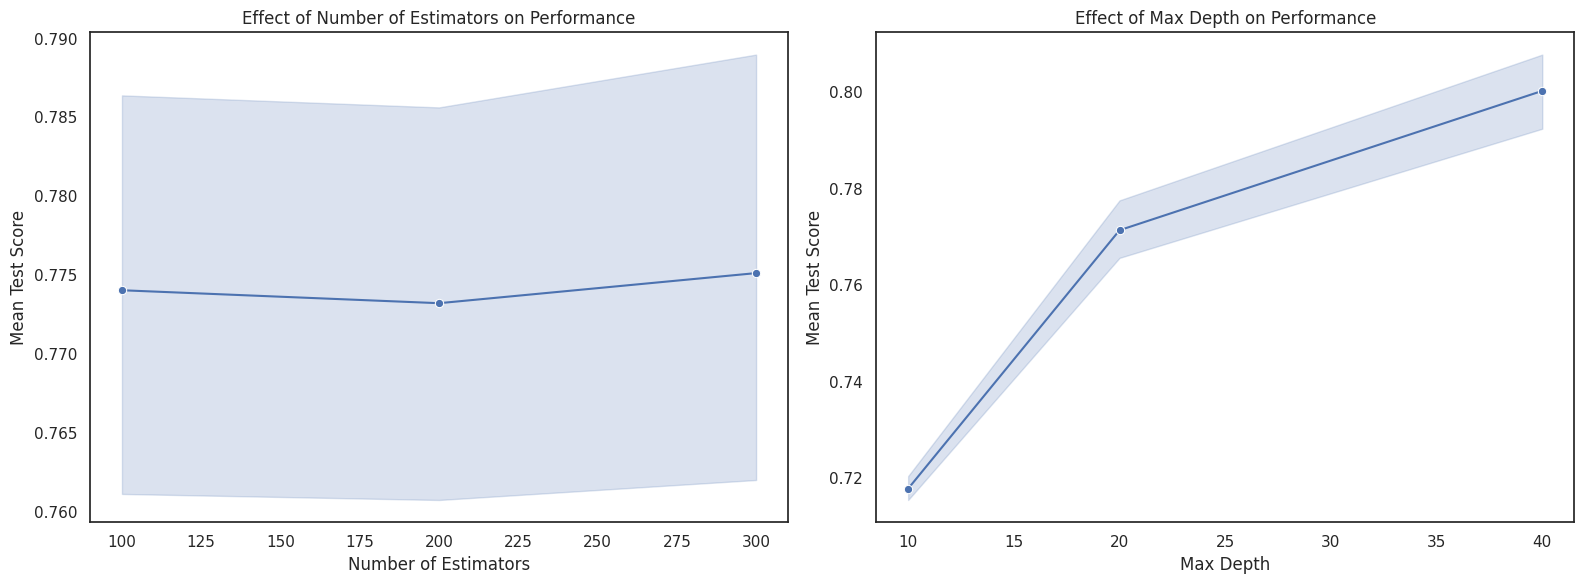

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the effect of 'n_estimators' on the mean test score
sns.lineplot(data=results_df, x='param_n_estimators', y='mean_test_score', ax=ax[0], marker='o')
ax[0].set_title('Effect of Number of Estimators on Performance')
ax[0].set_xlabel('Number of Estimators')
ax[0].set_ylabel('Mean Test Score')

# Plotting the effect of 'max_depth' on the mean test score
sns.lineplot(data=results_df, x='param_max_depth', y='mean_test_score', ax=ax[1], marker='o')
ax[1].set_title('Effect of Max Depth on Performance')
ax[1].set_xlabel('Max Depth')
ax[1].set_ylabel('Mean Test Score')

plt.tight_layout()
plt.savefig('grid_search_results.png')
plt.show()

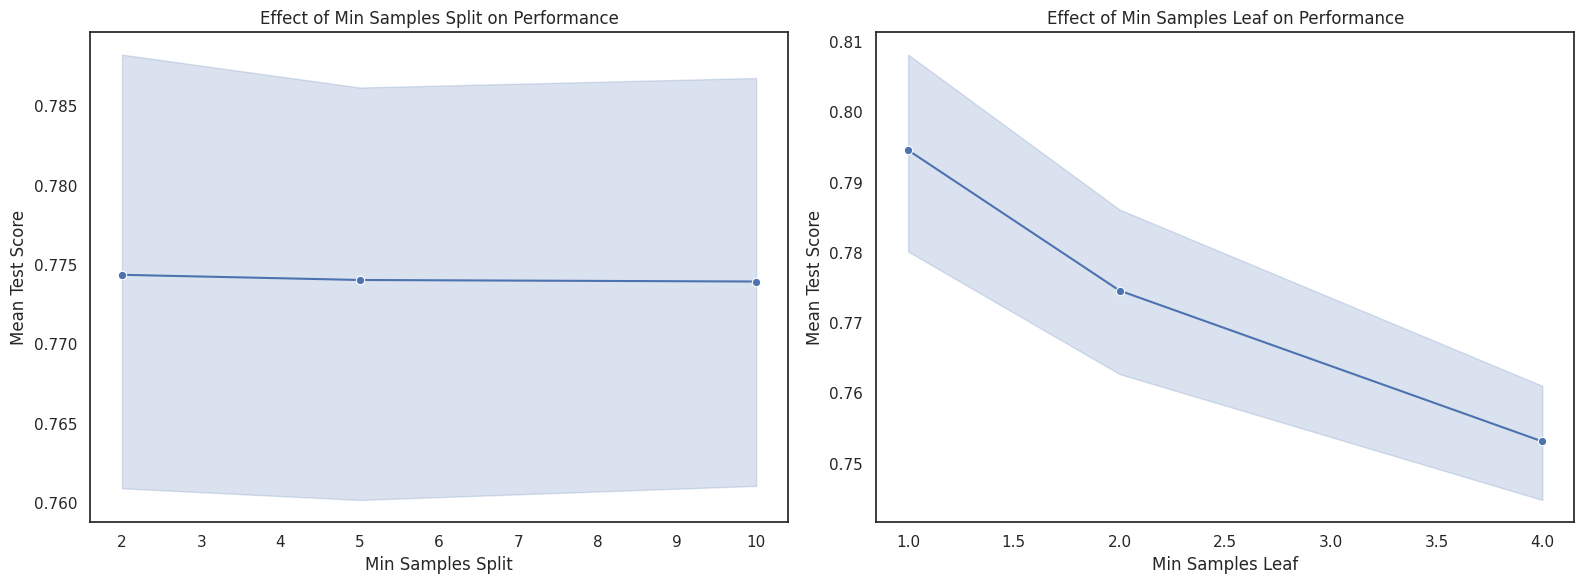

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the effect of 'min_samples_split' on the mean test score
sns.lineplot(data=results_df, x='param_min_samples_split', y='mean_test_score', ax=ax[0], marker='o')
ax[0].set_title('Effect of Min Samples Split on Performance')
ax[0].set_xlabel('Min Samples Split')
ax[0].set_ylabel('Mean Test Score')

# Plotting the effect of 'min_samples_leaf' on the mean test score
sns.lineplot(data=results_df, x='param_min_samples_leaf', y='mean_test_score', ax=ax[1], marker='o')
ax[1].set_title('Effect of Min Samples Leaf on Performance')
ax[1].set_xlabel('Min Samples Leaf')
ax[1].set_ylabel('Mean Test Score')

plt.tight_layout()
plt.savefig('grid_search_results_2.png')
plt.show()

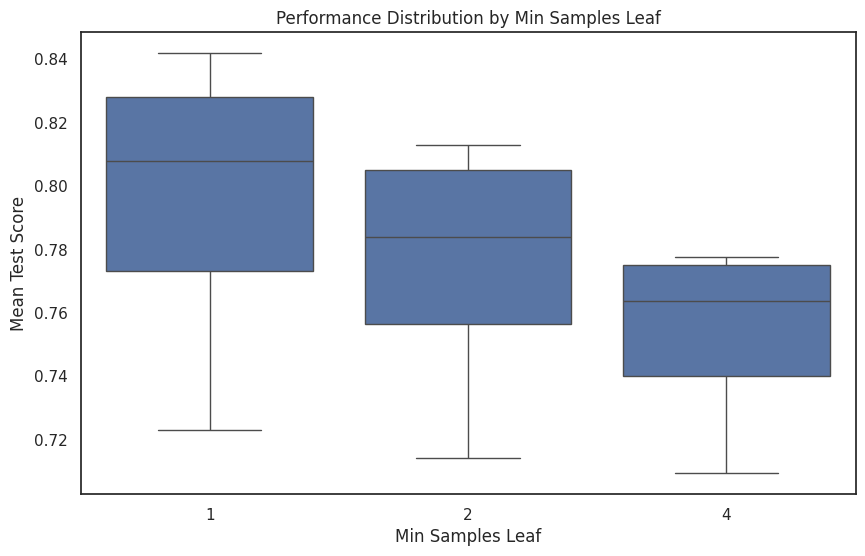

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='param_min_samples_leaf', y='mean_test_score', data=results_df)
plt.title('Performance Distribution by Min Samples Leaf')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Mean Test Score')
plt.show()

In [ ]:
# prepare features and labels
X = df['Sentence']
y = df['Label']

#### 7.3 Best Model Performance <a class="anchor" id="seven-three"></a>

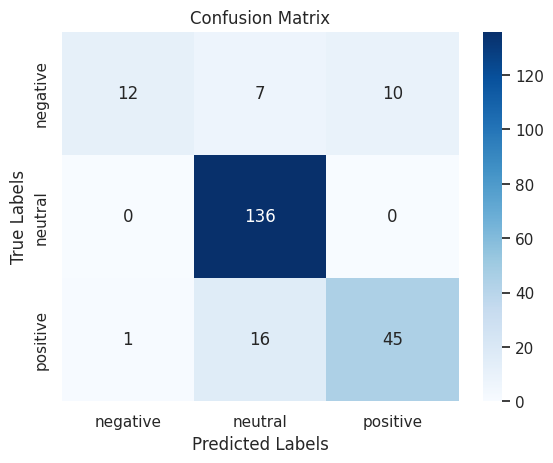

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('grid_search_results_3.png')
plt.show()

### Model 1 - MLP

In [ ]:
# Set the seeds for NumPy, TensorFlow, and random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
# Define the input layer
input_base = Input(shape=(NB_WORDS,))

# Create layers by applying them successively
hidden_base1 = Dense(64, activation='relu')(input_base)
hidden_base2 = Dense(64, activation='relu')(hidden_base1)
output_base = Dense(3, activation='softmax')(hidden_base2)

# Create a model from input and output
base_model = Model(inputs=input_base, outputs=output_base, name='Baseline_model')
base_model.summary()

Model: "Baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable params: 644419 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)

Optimal epoch for minimum validation loss is: 19


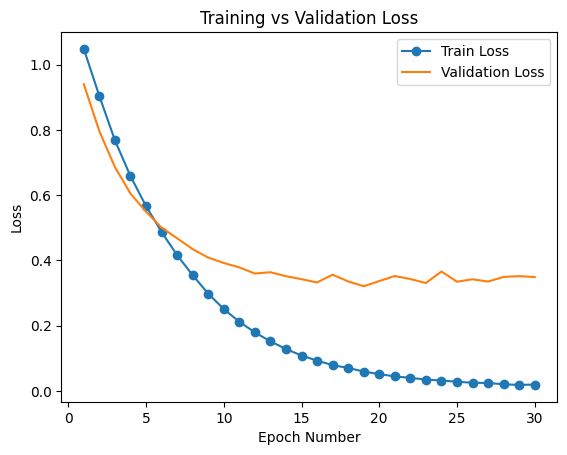

In [ ]:
eval_metric(base_model, base_history, 'loss')

In [ ]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)

8/8 [==============================] - 0s 10ms/step - loss: 0.4519 - accuracy: 0.8899

Test accuracy: 88.99%


#### i) Reduce the networks capacity

In [ ]:
# Define the input layer
input_reduced = Input(shape=(NB_WORDS,))

# Create layers by applying them successively
hidden_reduced = Dense(16, activation='relu')(input_reduced)
output_reduced = Dense(3, activation='softmax')(hidden_reduced)

# Create a model from input and output
reduced_model = Model(inputs=input_reduced, outputs=output_reduced, name='Reduced_model')
reduced_model.summary()

Model: "Reduced_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_7 (Dense)             (None, 16)                160016    
                                                                 
 dense_8 (Dense)             (None, 3)                 51        
                                                                 
Total params: 160067 (625.26 KB)
Trainable params: 160067 (625.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)

Optimal epoch for minimum validation loss is: 30


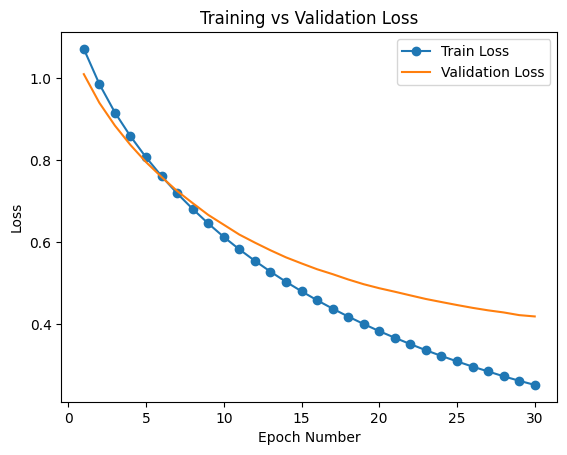

In [ ]:
eval_metric(reduced_model, reduced_history, 'loss')

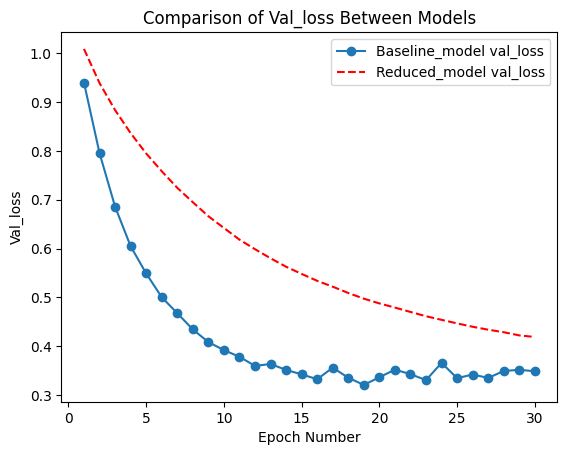

In [ ]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

In [ ]:
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)

8/8 [==============================] - 0s 4ms/step - loss: 0.3540 - accuracy: 0.8855

Test accuracy: 88.55%


#### ii) L2 Regularisation

In [ ]:
# Define the input layer
input_reg = Input(shape=(NB_WORDS,))

# Create layers by applying them successively with L2 regularization
hidden_reg1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_reg)
hidden_reg2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_reg1)
output_reg = Dense(3, activation='softmax')(hidden_reg2)

# Create a model from input and output
reg_model = Model(inputs=input_reg, outputs=output_reg, name='L2_Regularization_model')
reg_model.summary()

Model: "L2_Regularization_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_9 (Dense)             (None, 64)                640064    
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable params: 644419 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Optimal epoch for minimum validation loss is: 30


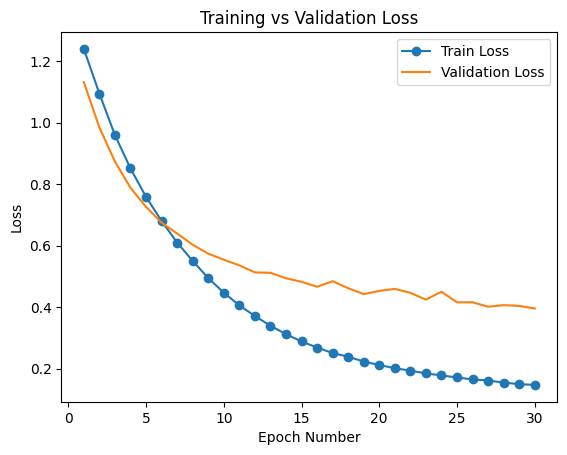

In [ ]:
eval_metric(reg_model, reg_history, 'loss')

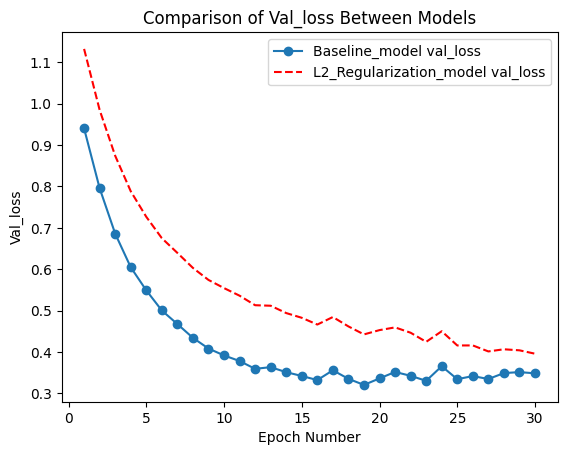

In [ ]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

In [ ]:
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)

8/8 [==============================] - 0s 4ms/step - loss: 0.4245 - accuracy: 0.8855

Test accuracy: 88.55%


#### iii) Dropout Layers

In [ ]:
# Define the input layer
input_dropout = Input(shape=(NB_WORDS,), name='input_dropout')

# Create layers by applying them successively
hidden_dropout1 = Dense(64, activation='relu', name='hidden_dropout1')(input_dropout)
dropout1 = Dropout(0.5, name='dropout1')(hidden_dropout1)  # First dropout layer
hidden_dropout2 = Dense(64, activation='relu', name='hidden_dropout2')(dropout1)
dropout2 = Dropout(0.5, name='dropout2')(hidden_dropout2)  # Second dropout layer
output_dropout = Dense(3, activation='softmax', name='output_dropout')(dropout2)

# Create a model from input and output
drop_model = Model(inputs=input_dropout, outputs=output_dropout, name='Dropout_layers_model')
drop_model.summary()

Model: "Dropout_layers_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (InputLayer)  [(None, 10000)]           0         
                                                                 
 hidden_dropout1 (Dense)     (None, 64)                640064    
                                                                 
 dropout1 (Dropout)          (None, 64)                0         
                                                                 
 hidden_dropout2 (Dense)     (None, 64)                4160      
                                                                 
 dropout2 (Dropout)          (None, 64)                0         
                                                                 
 output_dropout (Dense)      (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable param

In [ ]:
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

Optimal epoch for minimum validation loss is: 27


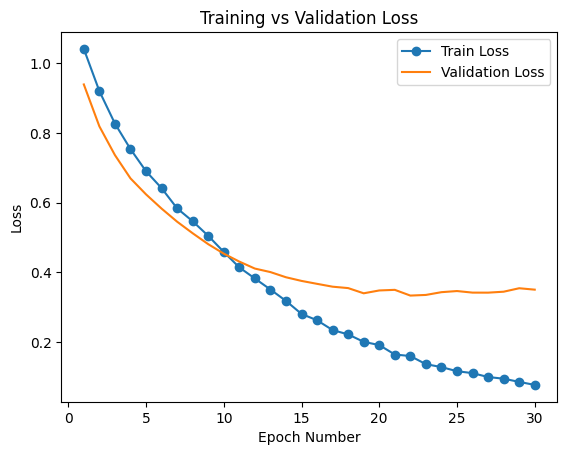

In [ ]:
eval_metric(drop_model, drop_history, 'loss')

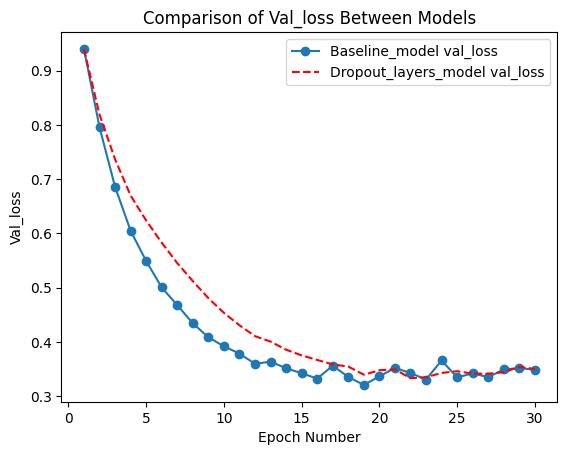

In [ ]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

In [ ]:
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

8/8 [==============================] - 0s 4ms/step - loss: 0.4989 - accuracy: 0.9031

Test accuracy: 90.31%


### Combined

In [ ]:
# Define the input layer
input_reg_reduced = Input(shape=(NB_WORDS,), name='input_reg_reduced')

# Create a reduced layers model and applying them successively with L2 regularization
hidden_reg_reduced = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.002), name='hidden_reg_reduced')(input_reg_reduced)
output_reg_reduced = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.002), name='output_reg_reduced')(hidden_reg_reduced)

# Create a model from input and output
reg_reduced_model = Model(inputs=input_reg_reduced, outputs=output_reg_reduced, name='Reduced_model_with_L2')
reg_reduced_model.summary()


Model: "Reduced_model_with_L2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_reg_reduced (InputLa  [(None, 10000)]           0         
 yer)                                                            
                                                                 
 hidden_reg_reduced (Dense)  (None, 16)                160016    
                                                                 
 output_reg_reduced (Dense)  (None, 3)                 51        
                                                                 
Total params: 160067 (625.26 KB)
Trainable params: 160067 (625.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
reg_red_history = deep_model(reg_reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_red_min = optimal_epoch(reg_red_history)

Optimal epoch for minimum validation loss is: 30


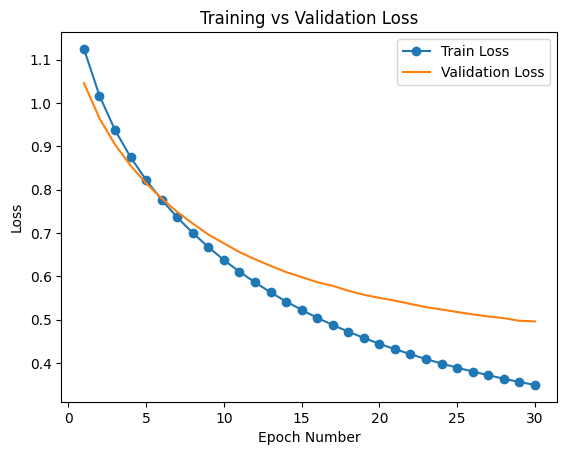

In [ ]:
eval_metric(reg_reduced_model, reg_red_history, 'loss')

In [ ]:
reg_red_results = test_model(reg_reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_red_min)

8/8 [==============================] - 0s 7ms/step - loss: 0.4616 - accuracy: 0.8767

Test accuracy: 87.67%


In [ ]:
# Retrieve model accuracies
accuracies = [
    base_results[1],
    reduced_results[1],
    reg_results[1],
    drop_results[1],
    reg_red_results[1]
]

model_names = ['Baseline', 'Reduced', 'Regularisation', 'Dropout', 'Regularised & Reduced']

# Creating a DataFrame
results_df = pd.DataFrame({
    'Model Variation': model_names,
    'Test Accuracy': accuracies
})

# Displaying the DataFrame
print(results_df)

         Model Variation  Test Accuracy
0               Baseline       0.889868
1                Reduced       0.885463
2         Regularisation       0.885463
3                Dropout       0.903084
4  Regularised & Reduced       0.876652


#### Hyperparameter Tuning - Using Random Search

In [ ]:
class DropoutHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = NB_WORDS
        self.num_classes = num_classes

    def build(self, hp):
        input_layer = Input(shape=(self.input_shape,), name='input_layer')

        # First dense layer with variable units and dropout
        units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
        dropout_rate1 = hp.Float('dropout1_rate', min_value=0.0, max_value=0.5, step=0.1)
        x = Dense(units1, activation='relu', name='hidden_1')(input_layer)
        x = Dropout(dropout_rate1, name='dropout_1')(x)

        # Second dense layer with variable units and dropout
        units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
        dropout_rate2 = hp.Float('dropout2_rate', min_value=0.0, max_value=0.5, step=0.1)
        x = Dense(units2, activation='relu', name='hidden_2')(x)
        x = Dropout(dropout_rate2, name='dropout_2')(x)

        # Output layer
        output_layer = Dense(self.num_classes, activation='softmax', name='output_layer')(x)

        # Build model
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model




In [ ]:
hypermodel = DropoutHyperModel(input_shape=input_shape, num_classes=num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='dropout_tuning'
)

# Assuming X_train, y_train are properly preprocessed and available
tuner.search(X_train_rest, y_train_rest, epochs=10, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Trial 50 Complete [00h 00m 12s]
val_accuracy: 0.8828337788581848

Best val_accuracy So Far: 0.8964577913284302
Total elapsed time: 00h 25m 33s
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10000)]           0         
                                                                 
 hidden_1 (Dense)            (None, 192)               1920192   
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 hidden_2 (Dense)            (None, 128)               24704     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 3)            

Note: 92% accuracy figure came from this tuning result, however, I tried to checked it in another cell it wouldn't run. So I kept this cell unexecuted to show the 92% figure. The only working random search for this model I could get to do again achieved 89.64%.

In [ ]:
#class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential(name='Dropout_layers_model')
        model.add(layers.Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(5397,)))
        model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.7, step=0.1)))
        model.add(layers.Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.7, step=0.1)))
        model.add(layers.Dense(3, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

#hypermodel = MyHyperModel()

#tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir2',
    project_name='hparam_tuning2'
)

#tuner.search(X_train, y_train, epochs=10, validation_split=0.2)
#best_model = tuner.get_best_models(num_models=1)[0]

Trial 50 Complete [00h 00m 33s]
val_accuracy: 0.906862735748291

Best val_accuracy So Far: 0.9215686321258545
Total elapsed time: 00h 21m 54s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


####RNN

In [ ]:
X = df['Sentence']
y = df['Label']

#Tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
max_length = max([len(x) for x in X_sequences])
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_onehot, test_size=0.2, random_state=42)

In [ ]:
# Define a learning rate
learning_rate = 0.0001

# Instantiate optimizer with the learning rate
optimizer = Adam(learning_rate=learning_rate)

model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=max_length),
    LSTM(84, return_sequences=False),
    Dense(y_onehot.shape[1], activation='softmax')
])

# Compile  model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
57/57 [==============================] - 5s 49ms/step - loss: 1.0687 - accuracy: 0.6157 - val_loss: 1.0279 - val_accuracy: 0.6093
Epoch 2/25
57/57 [==============================] - 2s 39ms/step - loss: 0.9407 - accuracy: 0.6157 - val_loss: 0.9073 - val_accuracy: 0.6093
Epoch 3/25
57/57 [==============================] - 3s 45ms/step - loss: 0.9053 - accuracy: 0.6157 - val_loss: 0.9012 - val_accuracy: 0.6093
Epoch 4/25
57/57 [==============================] - 3s 49ms/step - loss: 0.8906 - accuracy: 0.6157 - val_loss: 0.8813 - val_accuracy: 0.6093
Epoch 5/25
57/57 [==============================] - 2s 38ms/step - loss: 0.8167 - accuracy: 0.6173 - val_loss: 0.7084 - val_accuracy: 0.6336
Epoch 6/25
57/57 [==============================] - 2s 39ms/step - loss: 0.5607 - accuracy: 0.6996 - val_loss: 0.6516 - val_accuracy: 0.6909
Epoch 7/25
57/57 [==============================] - 2s 36ms/step - loss: 0.4952 - accuracy: 0.7134 - val_loss: 0.6296 - val_accuracy: 0.6887
Epoch 8/25
57

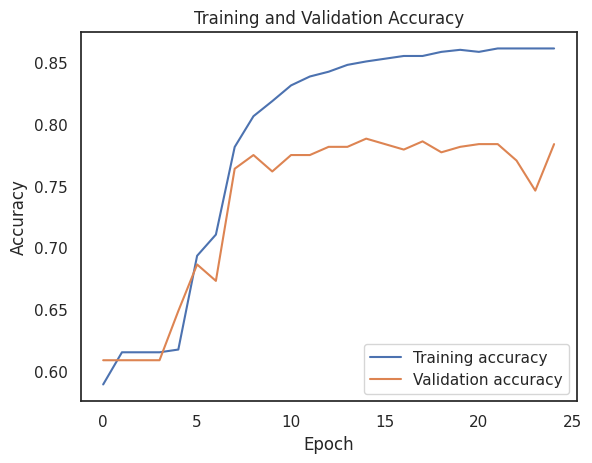

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7773 - loss: 0.8281
Test Loss: 0.7869555950164795, Test Accuracy: 0.7836644649505615


In [ ]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

##Hyperparameter Tuning through a random search

In [ ]:
class MyHyperModel(HyperModel):
    def __init__(self, max_length, vocab_size, num_classes):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        # Embedding layer
        model.add(Embedding(
            input_dim=self.vocab_size,
            output_dim=hp.Int('embedding_output_dim', min_value=8, max_value=64, step=8),
            input_length=self.max_length
        ))
        # LSTM layer
        model.add(LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
            return_sequences=False
        ))
        # Dropout layer
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))
        # Compile the model
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


hypermodel = MyHyperModel(max_length=max_length, vocab_size=10000, num_classes=y_onehot.shape[1])

# Create the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='keras_tuning_lstm'
)

# Performing RandomSearch
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]


Trial 10 Complete [00h 01m 36s]
val_accuracy: 0.8013244867324829

Best val_accuracy So Far: 0.8587196469306946
Total elapsed time: 00h 22m 24s


Best accuracy for this model is 85.87%, which is around a 7% improvment from the original model.

**Reference List**



Functions and some guidance on modelling was guided by this page
https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e

Generative AI was also used to in coding assistance.
